# District

In [1]:
district = "LUCKNOW"

# Nutrient

In [2]:
import pandas as pd
file_path3 = "Nutrient (2).csv"   # change to your path
df3 = pd.read_csv(file_path3)
# Weighted-average N, P, K, pH for a given district from df3
import numpy as np
import pandas as pd

# Fixed weights as provided
WEIGHTS = {
    "N": {"n_High": 560.0, "n_Medium": 420.0, "n_Low": 140.0},
    "P": {"p_High": 30.0, "p_Medium": 17.5, "p_Low": 5.0},
    "K": {"k_High": 300.0, "k_Medium": 200.0, "k_Low": 60.0},
    "pH": {"pH_Alkaline": 10.5, "pH_Acidic": 3.5, "pH_Neutral": 7.0},
}


def compute_district_npk_ph(district_name: str, data: pd.DataFrame = None):
    """Return weighted averages for N, P, K, and pH for the given district.

    - Matching is case-insensitive and ignores extra whitespace.
    - If any category counts sum to zero, returns NaN for that metric.
    - Output is a dict with keys: 'N', 'P', 'K', 'pH'.
    """
    if data is None:
        data = df3

    # Normalize district names for robust matching
    normalized_target = str(district_name).strip().upper()
    working = data.copy()
    working["_DistrictNorm"] = working["District"].astype(str).str.strip().str.upper()

    row = working[working["_DistrictNorm"] == normalized_target]
    if row.empty:
        raise ValueError(f"District '{district_name}' not found in df3")

    record = row.iloc[0]

    def weighted_average(column_weights: dict) -> float:
        columns = list(column_weights.keys())
        weights = list(column_weights.values())
        counts = [float(record[col]) for col in columns]
        total_count = sum(counts)
        if total_count == 0:
            return float("nan")
        weighted_sum = sum(c * w for c, w in zip(counts, weights))
        return weighted_sum / total_count

    n_value = weighted_average(WEIGHTS["N"])
    p_value = weighted_average(WEIGHTS["P"])
    k_value = weighted_average(WEIGHTS["K"])
    ph_value = weighted_average(WEIGHTS["pH"])

    return {"N": float(n_value), "P": float(p_value), "K": float(k_value), "pH": float(ph_value)}

inputt = compute_district_npk_ph(district)


# Weather

In [3]:
import os
import requests

OWM_API_KEY = "b93651e4ede9b7679f28a549efcae210"  # replace with your OpenWeather key

def get_coords(district, limit=5):
    """
    Returns (lat, lon) for a district using OpenWeather's direct geocoding API.
    Uses only the district name in the query.
    """
    url = "http://api.openweathermap.org/geo/1.0/direct"
    params = {
        "q": district,   # ✅ only district name
        "limit": 2,
        "appid": OWM_API_KEY,
    }
    resp = requests.get(url, params=params, timeout=15)
    resp.raise_for_status()
    results = resp.json()

    if not results:
        raise ValueError(f"No coordinates found for '{district}'")

    # return first match
    return results[0]["lat"], results[0]["lon"]

# --- example ---
if __name__ == "__main__":
    lat, lon = get_coords(district)
    print({"lat": lat, "lon": lon})


{'lat': 26.8381, 'lon': 80.9346001}


In [4]:
import requests
import pandas as pd

url1 = (
    "https://api.open-meteo.com/v1/forecast"
    f"?latitude={lat}&longitude={lon}"
    "&daily=temperature_2m_mean,precipitation_sum"
    "&timezone=Asia/Kolkata"
    "&forecast_days=16"
)

url2 = (
    "https://api.open-meteo.com/v1/forecast"
    f"?latitude={lat}&longitude={lon}"
    "&hourly=relative_humidity_2m"
    "&timezone=Asia/Kolkata"
    "&forecast_days=16"
)

resp = requests.get(url1)
data = resp.json()

resp2 = requests.get(url2)
data2 = resp2.json()

df = pd.DataFrame({
    'date': data['daily']['time'],
    'temp': data['daily']['temperature_2m_mean'],
    'precip_mm': data['daily']['precipitation_sum']
})

df2 = pd.DataFrame({
    'date': data2['hourly']['time'],
    'humidity': data2['hourly']['relative_humidity_2m']
})

df2_daily_src = df2.copy()
df2_daily_src["date"] = pd.to_datetime(df2_daily_src["date"]).dt.strftime("%Y-%m-%d")

# Group by date and take mean humidity
humidity_daily = (
    df2_daily_src.groupby("date", as_index=False)["humidity"].mean()
    .rename(columns={"humidity": "humidity_mean"})
)

# Merge daily mean humidity into df as the last column
# Rename to 'humidity' to match expected column name
df = df.merge(
    humidity_daily.rename(columns={"humidity_mean": "humidity"}),
    on="date",
    how="left"
)

daily_temp_avg = df["temp"]
avg_prec_16d = float(df["precip_mm"].mean())
avg_temp_16d = float(daily_temp_avg.mean())
avg_humidity_16d = float(df2["humidity"].mean())

'''print(f"Avg precipitation (16 days): {avg_prec_16d:.2f} mm")
print(f"Avg temperature (16 days): {avg_temp_16d:.2f} °C")
print(f"Avg humidity (16 days): {avg_humidity_16d:.2f} %")'''

# Add these averages into the inputt dict (create if missing)
try:
    inputt
except NameError:
    inputt = {}

inputt.update({
    "temperature": avg_temp_16d,
    "humidity": avg_humidity_16d,
    "rainfall": avg_prec_16d,
})

new_data = {k: v for k, v in inputt.items() if k != 'pH'}  # remove pH first
# Insert pH before rainfall
new_data = {**{k: v for k, v in new_data.items() if k != 'rainfall'},
            'pH': inputt['pH'],
            'rainfall': inputt['rainfall']}

val_arr = np.array(list(new_data.values()), dtype=float)


In [5]:
val_arr

array([140.6998542 ,  16.63299313, 205.66132056,  29.13125   ,
        75.89583333,   7.00874818,   5.21875   ])

In [35]:
val_arr

array([[140.15      ,  16.35119048, 187.7547619 ,  28.2125    ,
         82.40625   ,   7.00083333,   5.63125   ]])

In [44]:
val_arr

array([[140.6998542 ,  16.63299313, 205.66132056,  28.30625   ,
         81.03385417,   7.00874818,   6.53125   ]])

✅ Model and LabelEncoder saved!
Accuracy: 0.990909090909091

Classification Report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.90      0.95        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       0.95      1.00      0.98        20
   muskmelon       1.00      1.00      1.00       

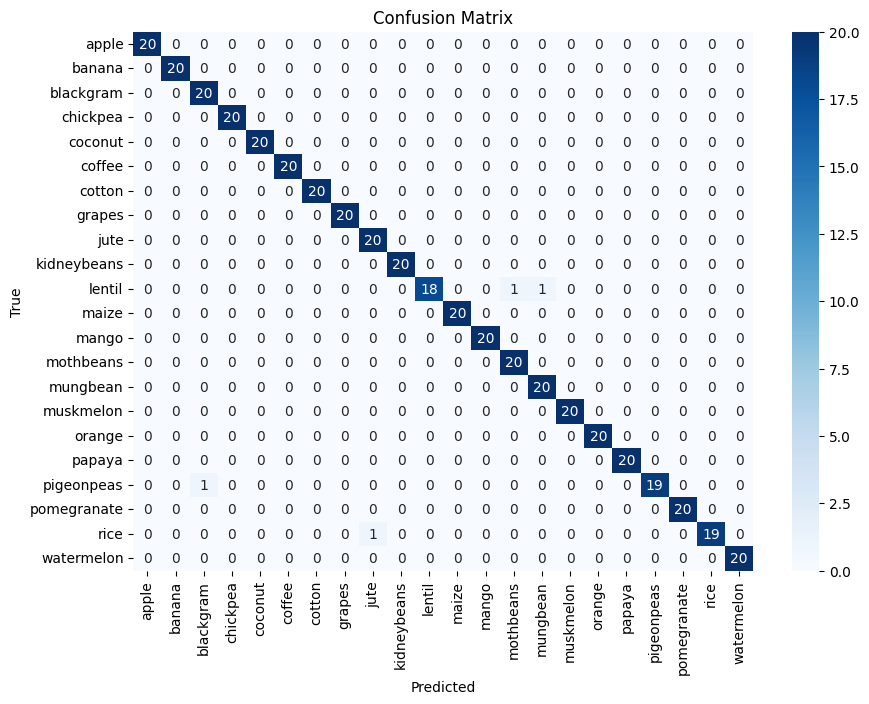

In [42]:
file_path2 = "Crop_recommendation.csv"   # change to your path
df2 = pd.read_csv(file_path2)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib   # for saving/loading models

# === Load your dataset ===
df = df2.copy()   # replace with your dataframe

# === Features and labels ===
X = df.drop("label", axis=1)
y = df["label"]

# Encode labels into numeric form
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# === Train XGBoost Classifier ===
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    random_state=42,
    tree_method="hist",    # ✅ faster & avoids some SciPy sparse issues
    use_label_encoder=False # ✅ suppresses old warnings
)
model.fit(X_train, y_train)

# === Save the model and encoder ===
joblib.dump(model, "xgb_model.pkl")
joblib.dump(le, "label_encoder.pkl")
print("✅ Model and LabelEncoder saved!")

# === Load back the model & encoder (for inference) ===
loaded_model = joblib.load("xgb_model.pkl")
loaded_le = joblib.load("label_encoder.pkl")

# === Evaluate ===
y_pred = loaded_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=loaded_le.classes_))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=loaded_le.classes_,
            yticklabels=loaded_le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [6]:
import joblib
import numpy as np

# === Load saved model and encoder ===
model = joblib.load("xgb_model.pkl")
le = joblib.load("label_encoder.pkl")

# Convert to 2D array for model
val_arr = np.array(val_arr).reshape(1, -1)

# === Make prediction ===
pred_encoded = model.predict(val_arr)[0]          # numeric prediction
pred_label = le.inverse_transform([pred_encoded]) # convert to crop name

print("Predicted Crop:", pred_label[0])


Predicted Crop: muskmelon


In [7]:
import joblib
import numpy as np

# === Load saved model and encoder ===
model = joblib.load("xgb_model.pkl")
le = joblib.load("label_encoder.pkl")

# Convert to 2D array for model
val_arr = np.array(val_arr).reshape(1, -1)

# === Get prediction probabilities ===
probs = model.predict_proba(val_arr)[0]  # probabilities for all classes

# Get top 3 class indices
top3_idx = np.argsort(probs)[-3:][::-1]

# Convert indices to labels
top3_labels = le.inverse_transform(top3_idx)

# Print top 3 predictions with probabilities
print("Top 3 Predicted Crops:")
for label, prob in zip(top3_labels, probs[top3_idx]):
    print(f"{label}: {prob:.4f}")


Top 3 Predicted Crops:
muskmelon: 0.9423
watermelon: 0.0335
cotton: 0.0032
